# Compute the potential-field data

Compute the potential-field data produced by the geological source simulated in the notebook `aula_5d_modelo_prismas_grav.ipynb`.

### Things we have to import

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [4]:
import time

In [5]:
import pickle

In [6]:
from gravmag import data_structures, utils, aux_vedo, constants, check
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [7]:
import vedo

In [8]:
# set the backend for vedo
vedo.settings.default_backend= 'vtk'
#vedo.settings.default_backend= '2d'

In [9]:
def model_cut(model, pmin, pmax):
    check.are_rectangular_prisms(model)
    check.is_integer(x=pmin, positive=True, include_zero=True)
    check.is_integer(x=pmax, positive=True, include_zero=True)
    if pmin >= pmax:
        raise ValueError('pmin must be greater than pmax')
    nprisms = model['x1'].size
    if pmin >= nprisms:
        raise ValueError('pmin must be smaller than num. of model prisms')
    if pmax >= nprisms:
        raise ValueError('pmax must be smaller than num. of model prisms')
    selected_model = dict()
    for element in model.keys():
        selected_model[element] = model[element][pmin:pmax+1]
    return selected_model

### Load the model

In [10]:
model = pickle.load(open('aula_5d/synthetic_bodies.pickle', 'rb'))

In [11]:
# model properties
print("(xmin, xmax) = ({:.3f}, {:.3f}) m".format(model['prisms']['x1'].min(), model['prisms']['x2'].max()))
print("(ymin, ymax) = ({:.3f}, {:.3f}) m".format(model['prisms']['y1'].min(), model['prisms']['y2'].max()))
print("(top min, top max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z1'].min(), model['prisms']['z1'].max()))
print("(bottom min, bottom max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z2'].min(), model['prisms']['z2'].max()))
print("number of prisms: {}".format(model['prisms']['x1'].size))

(xmin, xmax) = (-5183.098, 5010.617) m
(ymin, ymax) = (-3884.199, 6336.266) m
(top min, top max) = (0.000, 1000.000) m
(bottom min, bottom max) = (114.183, 1500.000) m
number of prisms: 305


### Points were we compute the synthetic data

In [12]:
data_points = dict()

In [13]:
# number of points along x and y
data_points['shape'] = (50, 50)

# minimum x, maximum x, minimum y and maximum y
data_points['area'] = [-5000, 5000, -4000, 6000]

In [14]:
# grid of computation points
data_points['grid'] = data_structures.grid_xy(
    area=data_points['area'], shape=data_points['shape'], z0=-100
)

In [15]:
# number of points along x and y
print('n. data = {}'.format(data_points['shape'][0]*data_points['shape'][1]))

# grid spacing
data_dx, data_dy = data_structures.grid_xy_spacing(area=data_points['area'], shape=data_points['shape'])
print('dx = {:.3f} m | dy = {:.3f} m'.format(data_dx, data_dy))

n. data = 2500
dx = 204.082 m | dy = 204.082 m


In [16]:
file_name = 'data_points.pickle'
with open('aula_5d/'+file_name, 'wb') as f:
    pickle.dump(data_points, f)

### Synthetic gravity data

In [17]:
gravity_data = dict()

#### Noise-free gravity disturbace data  (in mGal)

In [18]:
# Compute the vertical component of acceleration
gravity_data['gz'] = rp.grav(
    coordinates=data_structures.grid_xy_to_full_flatten(
        grid=data_points['grid'],
        grid_orientation='xy'
    ), 
    prisms=model['prisms'], 
    density=model['densities'], 
    field='z'
)

#### Noise-free gravity gradient tensor data  (in Eötvös)

In [19]:
# Compute the tensor components
tensor_components = ['xx', 'xy', 'xz', 'yy', 'yz', 'zz']
for component in tensor_components:
    gravity_data[component] = rp.grav(
          coordinates=data_structures.grid_xy_to_full_flatten(
              grid=data_points['grid'],
              grid_orientation='xy'
          ), 
          prisms=model['prisms'], 
          density=model['densities'], 
          field=component
    )

#### Save data

In [20]:
file_name = 'gravity_data.pickle'
with open('aula_5d/'+file_name, 'wb') as f:
    pickle.dump(gravity_data, f)

### Plot the computed gravity disturbance with Matplotlib

In [21]:
titles_tensor = ['gxx (E)', 'gxy (E)', 'gxz (E)', 'gyy (E)', 'gyz (E)', 'gzz (E)']
title_gz = ['gz (mGal)']
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

In [22]:
ranges_tensor = []
for component in tensor_components:
    ranges_tensor.append(np.max(np.abs(gravity_data[component])))
ranges_tensor = 0.9*np.max(np.array(ranges_tensor))

In [23]:
ranges_gz = np.max(np.abs(gravity_data['gz']))

In [24]:
mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

In [25]:
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x=data_points['grid']['x'],
    y=data_points['grid']['y'],
    shape=data_points['shape']
)

In [26]:
color = 'k'#3*(0.4,)

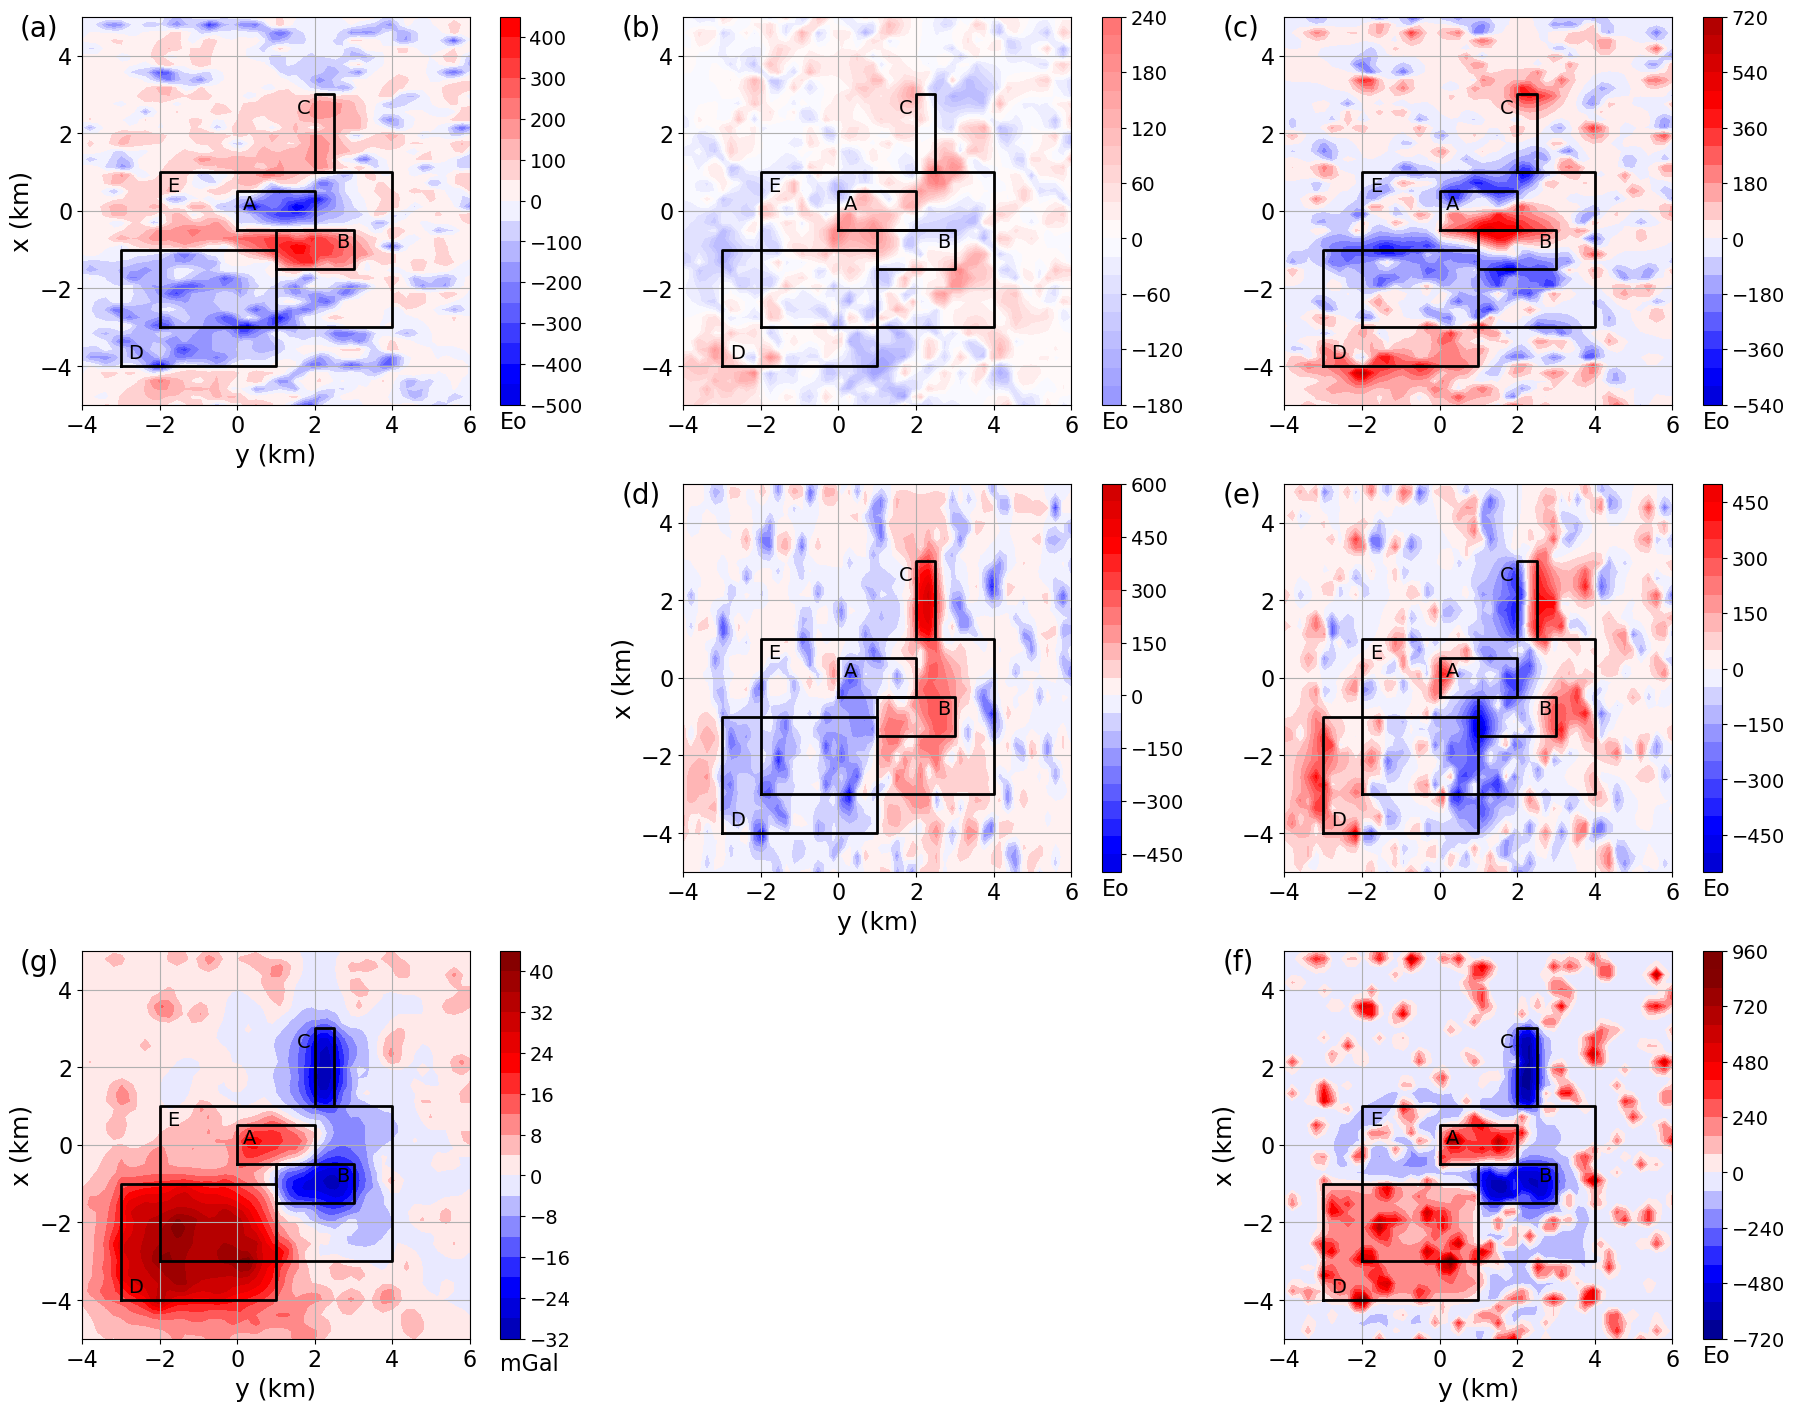

In [27]:
fig = plt.figure(layout= 'constrained', figsize=(18,14))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, component, title, label) in zip(
    mosaic_elements, tensor_components, titles_tensor, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=gravity_data[component],
                         grid_orientation='xy',
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('Eo', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

# gz
ax = mosaic['g']
ax.axis('scaled')
im = ax.contourf(Y*0.001, X*0.001, 
                 data_structures.grid_xy_full_flatten_to_matrix(
                     data=gravity_data['gz'],
                     grid_orientation='xy',
                     shape=data_points['shape']
                 ), 20, 
                 cmap='seismic', vmin=-ranges_gz, vmax=ranges_gz)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
cb.ax.set_xlabel('mGal', fontsize=16, loc='left', labelpad=10)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(g)', xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
plf.model_boundaries(
    ax,
    model=model_cut(model['prisms'], pmin=0, pmax=4),
    color=color,
    style='-',
    width='2'
)
ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a','d','f','g']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()